### Introduction: Data Sets and Parameters

For this analysis, I've chosen to use the 'The Numbers' data set to analyze budgets since it includes a fuller picture than some of the other options. For a qualitative look, I'll use IMDB to look at user reviews and Rotten Tomatoes to look at critic reviews.

These data sets use very different categorization & scoring methods, and have diffent data points. Therefor my methodology to analyze each will be unique, and I will treat them as separate sources. 

A quick note on some parameters: 
1. I will be looking at US data only to get a conststent picture of Microsoft's home market as a starting off point; 
2. I'll be cleaning out older movies - since the movie industry & video consumption is changing so rapidly at this time, I want to examine only the most recent data.

In [1]:
# First I am going to import all necessary libraries and data files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import budgets data
df_budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz', compression='gzip')

#import imdb data
df_imdb_basics = pd.read_csv('zippedData/imdb.title.basics.csv.gz', compression='gzip')
df_imdb_ratings = pd.read_csv('zippedData/imdb.title.ratings.csv.gz', compression='gzip')
df_imdb_akas = pd.read_csv('zippedData/imdb.title.akas.csv.gz', compression='gzip')

#import rotten tomatoes data
df_rt_info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep='\t', compression='gzip')
df_rt_rev = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep='\t', compression='gzip', encoding='iso-8859-1')

### Measures of Success 

So before I dive in, I'll outline my metrics for a successful movie:

1. __Positive return on investment:__ Because ultimately, a successful project makes money. I will look at overall domestic gross return as well as a secondary metric here.

2. __High user ratings:__ We want people to like the movie! This will help generate word-of-mouth promotion and social media chat to spread positive opinion. 

3. __High critical ratings:__ Strong critical reviews mean positive press, which will capture media attention. Having clout in the industry as well can mean getting put up for awards, which can be a great set up to draw in better talent to future films, and better funding from potential investors

First, I'll be looking at the movie budgets data. I want to see if I can get a sense of movies with highest return on investment. 

To do this, I need to convert the budget columns into integers and then add a column calculating return on investment. I am also going to clean out older movies, and add year and month columns so I can further analyze the data.

In [3]:
#convert to date time and add columns for month and year
df_budgets['release_date'] = pd.to_datetime(df_budgets['release_date'])
df_budgets['release_year'] = df_budgets['release_date'].dt.year
df_budgets['release_month'] = df_budgets['release_date'].dt.month
#clean out old movies
df_budgets = df_budgets[(df_budgets['release_year'] >= 2014)]

In [4]:
#make $$ columns into integers
df_budgets['production_budget'] = df_budgets['production_budget'].map(lambda price: int(price.replace("$", "").replace(",", "")))
df_budgets['domestic_gross'] = df_budgets['domestic_gross'].map(lambda price: int(price.replace("$", "").replace(",", "")))
df_budgets['worldwide_gross'] = df_budgets['worldwide_gross'].map(lambda price: int(price.replace("$", "").replace(",", "")))
#calculate ROI column
df_budgets['domestic_roi'] = df_budgets['domestic_gross'] / df_budgets['production_budget']

I'm going to examine ROI using the variables I have in this data set, which are release date-related. I'll create dataframes to look at ROI by month and year and plot the results. 

In [18]:
df_budgets.sort_values(['domestic_roi'], ascending = False).head(20)
df_roi = df_budgets.groupby(['release_year'])['domestic_roi'].mean()
df_roi = df_roi.reset_index()
# 2020 has no budget data in this set
df_roi = df_roi.drop(index = 6)
df_roi

,release_year,domestic_roi
0,2014,1.432386
1,2015,1.653406
2,2016,1.599537
3,2017,1.980350
4,2018,2.077434
5,2019,1.224815


In [6]:
df_roi_mo = df_budgets.groupby(['release_month'])['domestic_roi'].mean()
df_roi_mo = df_roi_mo.reset_index()
df_roi_mo.head(2)

,release_month,domestic_roi
0,1,1.620346
1,2,1.628038


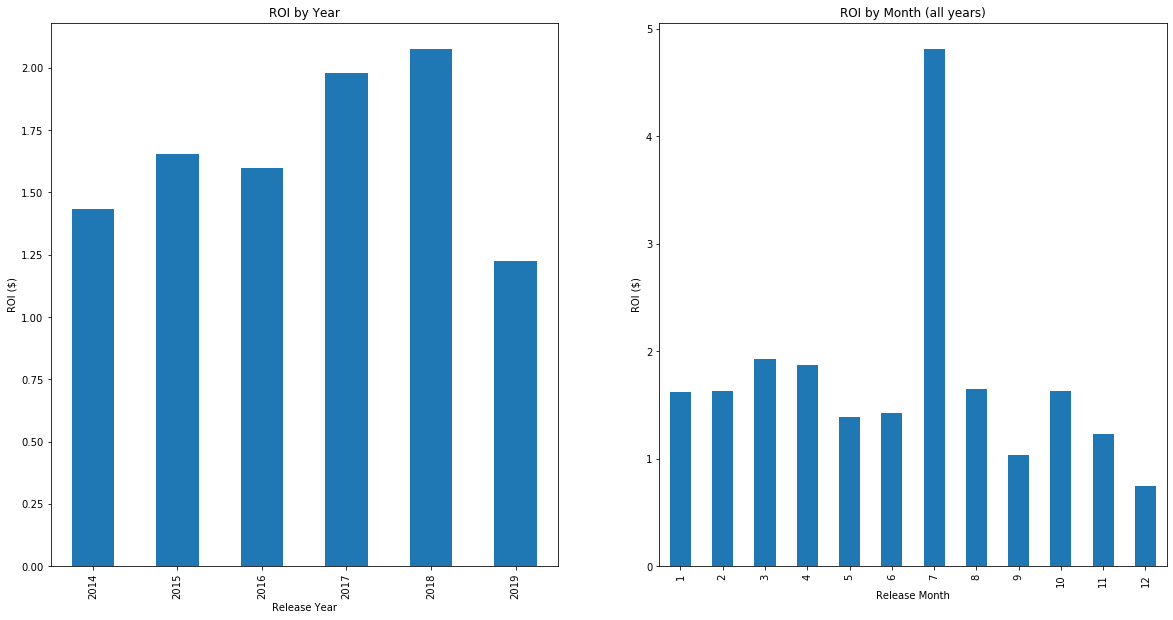

In [22]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 1)
df_roi.plot(x='release_year', y='domestic_roi', ax=ax1, kind = 'bar', legend = False)
ax1.set_title('ROI by Year')
ax1.set_xlabel('Release Year')
ax1.set_ylabel('ROI ($)')

ax2 = plt.subplot(1,2,2)
df_roi_mo.plot(x='release_month', y='domestic_roi', ax=ax2, kind = 'bar', legend = False)
ax2.set_title('ROI by Month (all years)')
ax2.set_xlabel('Release Month')
ax2.set_ylabel('ROI ($)')

plt.show()

So it looks like July is a definite winner - likely because there are often big summer releases, but also because more people are off work/school. Let's aim for our first movie to come out in July. 

More nuanced is that 2017 and 2018 were good years for the industry. Let's take a look at some July movies first to see if we get a sense of any trends, then some top 2017-2018 releases

In [27]:
df_july_movies = df_budgets[df_budgets['release_month'] == 7].sort_values(['domestic_roi'], ascending = False)
# the highest movie on this list, 'The Gallows', is a major outlier with a low production budget and a ~$500 ROI so I am dropping it
df_july_movies = df_july_movies.drop([5679])

In [52]:
import plotly.express as px
fig = px.scatter(df_july_movies, x='production_budget', y='domestic_roi', hover_data=['movie'], width=800, height=500)
fig.update_layout(title='July Movies: ROI vs Budget',
    xaxis_title='Production Budget',
    yaxis_title='ROI ($)')

fig.show()

The good news is, the majority of these movies have budgets on the lower end of this spread. To not get too risky, we can aim to start with a budget of ~50MM. These titles are diverse and contain horror, action, comedy and drama which gives us lots of options!

In [38]:
df_july_movies[df_july_movies['production_budget'] < 50000000].head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,domestic_roi
5685,86,2017-07-07,A Ghost Story,100000,1594798,2769782,2017,7,15.947980
4254,55,2016-07-22,Lights Out,5000000,67268835,148806510,2016,7,13.453767
5228,29,2018-07-20,Unfriended: Dark Web,1000000,8866745,16434588,2018,7,8.866745
3770,71,2014-07-18,The Purge: Anarchy,9000000,71562550,111534881,2014,7,7.951394
3541,42,2016-07-01,The Purge: Election Year,10000000,79042440,118514727,2016,7,7.904244
4894,95,2018-07-13,Eighth Grade,2000000,13539710,14341016,2018,7,6.769855
4484,85,2014-07-11,Boyhood,4000000,25379975,57273049,2014,7,6.344994
2498,99,2016-07-29,Bad Moms,20000000,113257297,180998716,2016,7,5.662865
4653,54,2018-07-06,Sorry to Bother You,3200000,17493096,18285560,2018,7,5.466592
3248,49,2018-07-04,The First Purge,13000000,69488745,136617305,2018,7,5.345288


In [54]:
df_good_years = df_budgets[(df_budgets['release_year'] == 2017) | (df_budgets['release_year'] == 2018)]
fig2 = px.scatter(df_good_years, x='production_budget', y='domestic_roi', hover_data=['movie'], width=800, height=600)
fig2.update_layout(title='2017-2018 Movies',
    xaxis_title='Production Budget',
    yaxis_title='ROI ($)')

fig.show()

So, similarly we get a diverse range of titles with most production budgets falling below $50k.

What if we took a different angle and didn't worry about budgets, but instead looked at what movies grosed the highest?

In [39]:
df_budgets.sort_values(['domestic_gross'], ascending = False).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,release_month,domestic_roi
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,2015,12,3.060988
41,42,2018-02-16,Black Panther,200000000,700059566,1348258224,2018,2,3.500298
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,2018,4,2.262718
33,34,2015-06-12,Jurassic World,215000000,652270625,1648854864,2015,6,3.033817
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,12,1.956408
43,44,2018-06-15,Incredibles 2,200000000,608581744,1242520711,2018,6,3.042909
44,45,2016-12-16,Rogue One: A Star Wars Story,200000000,532177324,1049102856,2016,12,2.660887
134,35,2017-03-17,Beauty and the Beast,160000000,504014165,1259199706,2017,3,3.150089
45,46,2016-06-17,Finding Dory,200000000,486295561,1021215193,2016,6,2.431478
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,5,1.388403


These movies all are all pretty major franchises, and in many cases, remakes or sequels. Unless we want to purchase or start a major movie franchise on our first try, let's use 'July Movies' as our goal.

So to recap the recommendations from this data analysis, which answers success metric #1: 

__1. Release a movie in July for the biggest return on investment__

__2. Start with a budget below $50MM since most July movies with high returns fell at or below this.__

Great, let's move on to #2 and #3, and start working on the ratings data.